In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
volodymyrpivoshenko_skin_cancer_lesions_segmentation_path = kagglehub.dataset_download('volodymyrpivoshenko/skin-cancer-lesions-segmentation')

print('Data source import complete.')


Using Colab cache for faster access to the 'skin-cancer-lesions-segmentation' dataset.
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os, glob, random, shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Input, Dropout
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define your paths
images_path = '/kaggle/input/skin-cancer-lesions-segmentation/data/images'
masks_path = '/kaggle/input/skin-cancer-lesions-segmentation/data/masks'

# Get all image and mask files
image_files = sorted(glob.glob(os.path.join(images_path, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(masks_path, '*.png')))

# Match by filename
image_basename_to_path = {os.path.basename(f): f for f in image_files}
mask_basename_to_path = {os.path.basename(f): f for f in mask_files}

# Strip extensions for matching
image_keys = {os.path.splitext(f)[0] for f in image_basename_to_path.keys()}
mask_keys = {os.path.splitext(f)[0] for f in mask_basename_to_path.keys()}

# Only keep pairs that exist in both directories
common_keys = image_keys & mask_keys

# Recreate matched image and mask pairs with valid extensions
image_paths = [image_basename_to_path[f"{k}.jpg"] for k in common_keys]
mask_paths = [mask_basename_to_path[f"{k}.png"] for k in common_keys]

In [ ]:
# Sort for reproducibility
image_paths.sort()
mask_paths.sort()

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

print(f"Train: {len(train_images)}")
print(f"Val: {len(val_images)}")
print(f"Test: {len(test_images)}")

Train: 7210
Val: 802
Test: 2003


In [ ]:
# Modify the image size to 128x128
def load_image_mask_pairs(image_paths, mask_paths):
    images = tf.io.read_file(image_paths)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, [128, 128])  # Increased resolution
    images = tf.cast(images, tf.float32) / 255.0

    masks = tf.io.read_file(mask_paths)
    masks = tf.image.decode_png(masks, channels=1)
    masks = tf.image.resize(masks, [128, 128])  # Increased resolution
    masks = tf.cast(masks > 127, tf.float32)
    return images, masks


In [ ]:
def get_dataset(image_paths, mask_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask_pairs, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = get_dataset(train_images, train_masks)
test_dataset = get_dataset(test_images, test_masks)
val_dataset = get_dataset(val_images, val_masks)

In [ ]:
def display_sample(images):
    plt.figure(figsize=(10,10))
    titles = ['Input Image','True Mask','Predicted Mask']

    for i in range(len(images)):
        plt.subplot(1,len(images),i+1)
        plt.title(titles[i])
        plt.imshow(array_to_img(images[i]))
        plt.axis('off')

    plt.show()

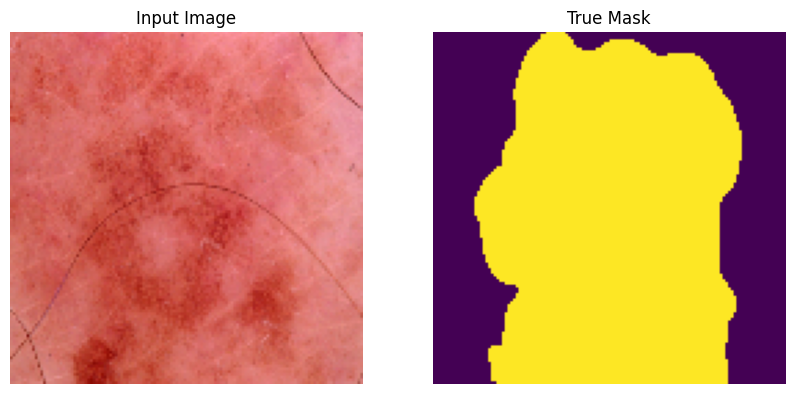

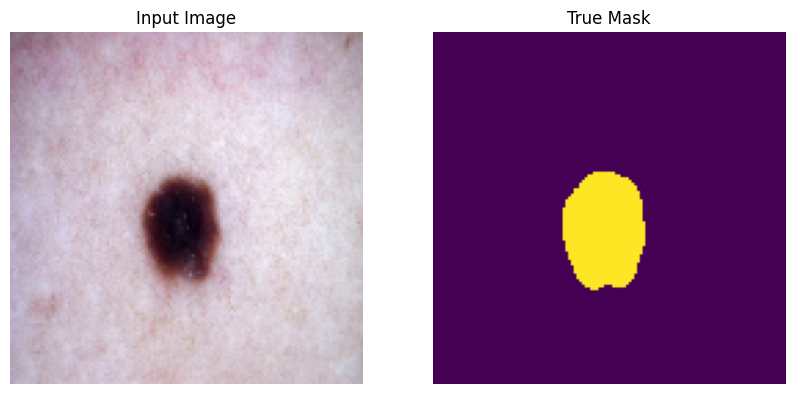

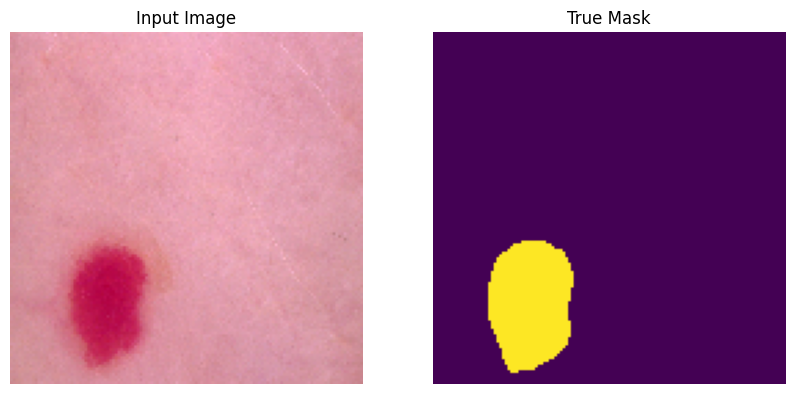

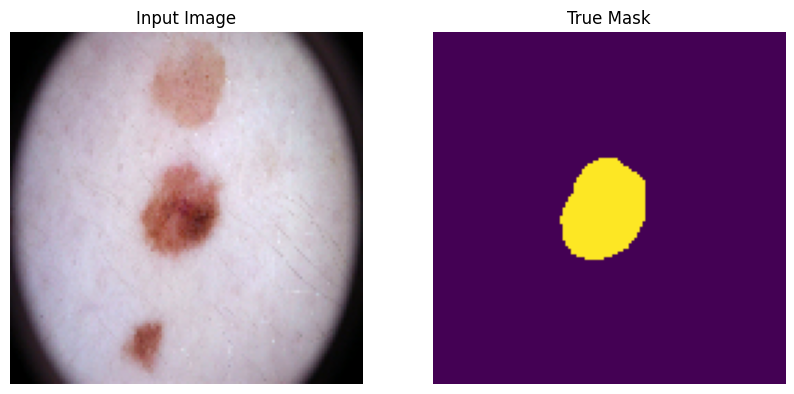

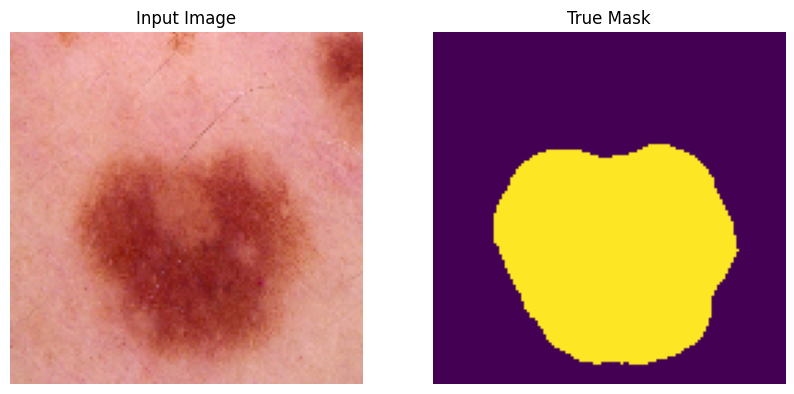

In [ ]:
for images, masks in train_dataset.take(5):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

In [ ]:
sample_image.shape

TensorShape([128, 128, 3])

In [ ]:
# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3]  # Added brightness variations
)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Input, Conv2DTranspose, concatenate, Add, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, MeanSquaredError
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Enhanced U-Net with residual connections and batch normalization
def double_conv_block(x, n_filters):
    # Adding BatchNormalization for better convergence
    x = Conv2D(filters=n_filters, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=n_filters, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

def downsample_block(x, n_filters):
    fwd_block = double_conv_block(x=x, n_filters=n_filters)
    x = MaxPool2D((2,2))(fwd_block)
    x = Dropout(0.3)(x)  # Add dropout for regularization
    return fwd_block, x

def upsample_block(x, conv_features, n_filters):
    x = Conv2DTranspose(filters=n_filters, kernel_size=(3,3), strides=2, padding='same')(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)  # Dropout for regularization
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(output_channels):
    inputs = Input(shape=(128, 128, 3))  # Changed input size to 128x128

    # Encoder Block
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Intermediate Block (Bottleneck)
    intermediate_block = double_conv_block(p4, 1024)

    # Decoder Block
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output Layer
    outputs = Conv2D(output_channels, 1, activation='softmax', padding='same')(u9)

    # Create the U-Net Model
    unet_model = Model(inputs, outputs, name='U-Net')
    return unet_model


In [ ]:
# Weighted Cross-Entropy Loss to address class imbalance
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau


def weighted_cross_entropy(y_true, y_pred):
    weights = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred) * weights)

# Use a combination of Dice and IoU Loss
def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true, axis=-1) + tf.reduce_sum(y_pred, axis=-1) + 1)

def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    union = tf.reduce_sum(tf.abs(y_true), axis=-1) + tf.reduce_sum(tf.abs(y_pred), axis=-1) - intersection
    return 1 - (intersection + 1e-5) / (union + 1e-5)

# Use both Dice and IoU loss together for training
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + iou_loss(y_true, y_pred)


In [ ]:
# Using AdamW optimizer with learning rate scheduler
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

# Learning Rate Scheduler (Adjusts during training)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)


In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.models import Model

# Double Convolution Block with BatchNormalization
def double_conv_block(x, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # Added Batch Normalization
    return x

# Downsample Block
def downsample_block(x, n_filters):
    fwd_block = double_conv_block(x=x, n_filters=n_filters)
    x = MaxPool2D((2, 2))(fwd_block)
    x = Dropout(0.3)(x)  # Add dropout for regularization
    return fwd_block, x

# Upsample Block
def upsample_block(x, conv_features, n_filters):
    x = Conv2DTranspose(filters=n_filters, kernel_size=(3, 3), strides=2, padding='same')(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)  # Dropout for regularization
    x = double_conv_block(x, n_filters)
    return x

# U-Net Model with Binary Segmentation Output
def build_unet_model(output_channels):
    inputs = Input(shape=(128, 128, 3))  # Changed input size to 128x128

    # Encoder Block
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Intermediate Block (Bottleneck)
    intermediate_block = double_conv_block(p4, 1024)

    # Decoder Block
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)  # Final decoder block (u9 is now correctly defined)

    # Final Output Layer (Sigmoid for Binary Segmentation)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u9)

    # Create the U-Net Model
    unet_model = Model(inputs, outputs, name='U-Net')
    return unet_model

# Define output channels for binary segmentation
output_channels = 1

# Build and compile the model
unet_model = build_unet_model(output_channels)

# Compile the model with binary cross-entropy loss for binary segmentation
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Model Summary
unet_model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]  

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.config.run_functions_eagerly(True)


# Recreate the AdamW optimizer after changes in the model
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

# Recompile the model with the new optimizer
unet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
history = unet_model.fit(train_dataset,
                        epochs=20,
                        steps_per_epoch=len(train_images)//32,
                        validation_data=val_dataset,
                        validation_steps=len(val_images)//32,
                        callbacks=[lr_scheduler])

# Evaluate on the test dataset
evaluation_result = unet_model.evaluate(test_dataset)

# Unpack the evaluation result
test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 204s 856ms/step - accuracy: 0.8522 - loss: 0.3526 - precision_1: 0.7156 - recall_1: 0.7851 - val_accuracy: 0.8898 - val_loss: 0.3871 - val_precision_1: 0.9699 - val_recall_1: 0.5917 - learning_rate: 1.0000e-04
Epoch 2/20
  1/225 ━━━━━━━━━━━━━━━━━━━━ 13:11 4s/step - accuracy: 0.9623 - loss: 0.1070 - precision_1: 0.9511 - recall_1: 0.9066

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9623 - loss: 0.1070 - precision_1: 0.9511 - recall_1: 0.9066 - val_accuracy: 0.8902 - val_loss: 0.3838 - val_precision_1: 0.9721 - val_recall_1: 0.5935 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 192s 855ms/step - accuracy: 0.9435 - loss: 0.1552 - precision_1: 0.9134 - recall_1: 0.8677 - val_accuracy: 0.9419 - val_loss: 0.1773 - val_precision_1: 0.9672 - val_recall_1: 0.8031 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9201 - loss: 0.2017 - precision_1: 0.9713 - recall_1: 0.7847 - val_accuracy: 0.9410 - val_loss: 0.1830 - val_precision_1: 0.9700 - val_recall_1: 0.7964 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 192s 853ms/step - accuracy: 0.9514 - loss: 0.1314 - precision_1: 0.9197 - recall_1: 0.8926 - val_accuracy: 0.9557 - val_loss: 0.1203 - val_precision_1: 0.9555 - val_recall_1: 0.8698 - learning_rate: 1.0000e-04
Epoch 6/20
225/22

Text(0.5, 1.0, 'Accuracy over Epochs')

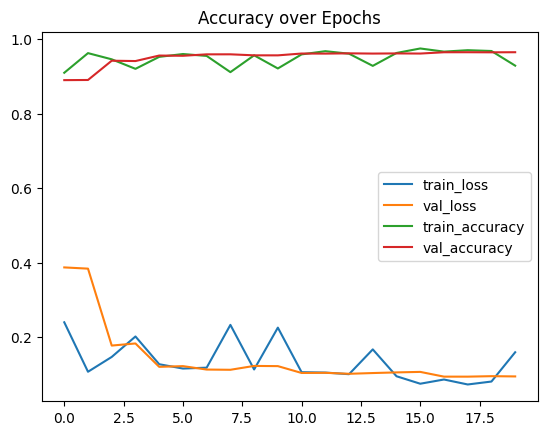

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
